# Effect of statistical uncertainty

Probability distributions of load variables are typically based on limited data, leading to (statistical) uncertainty in the estimates of loads for given exceedance probabilities.

Let's consider a load variable $X$ and a random variable $V$, which represents the associated statistical uncertainty. The probability $P(X>x)$ is known, as well as the probability distribution of $V$. Now, let's define a new variable 
$X_{incl}$ as $X+V$. The goal is to estimate $P(X_{incl}>x)$.

In this example, we will demonstrate how to calculate the effect of statistical uncertainty on the exceedance probability of river discharge.

First, let's import the necessary packages:

In [1]:
from ptk import *
from scipy import interpolate
import matplotlib.pyplot as plt

We consider the following limit state function:

$Z = w - (Q +V)$

where: <br>

$Q$ is the river discharge, without the statistical uncertainty (m3/s) <br>
$V$ is the statistical uncertainty (m3/s) <br>
$w$ represents a specific value of the river discharge (m3/s)

The river discharge $Q$ is represented as an empirical cumulative distribution function (CDF). The exceedance probabilities of the river discharge for different stages are defined as follows:

In [2]:
Q_Pf = {"Q": [5940,7970,9130,10910,12770,14000,14840,14970,15520,16270,16960,17710],
        "Pf": [0.083333333,0.033333333,0.016666667,0.005555556,0.001666667,0.000555556,0.000166667,0.000133333,5.55556E-05,1.66667E-05,5.55556E-06,1.66667E-06]}

The statistical uncertainty $V$ is normally distributed with a mean of 0. The standard deviation $σ$ is a function of $Q$, defined as follows:

In [3]:
sigma = {"Q": [5939.9,5940,7970,9130,10910,12770,14000,14840,14970,15520,16270,16960,17710],
         "deviation": [340,340,440,500,600,700,560,620,640,750,930,1120,1350]}

We define the following limit state function:

In [4]:
def limit_state_function(Q, U, w):

    sigma = {"Q": [5939.9,5940,7970,9130,10910,12770,14000,14840,14970,15520,16270,16960,17710],
         "deviation": [340,340,440,500,600,700,560,620,640,750,930,1120,1350]}

    f = interpolate.interp1d(sigma["Q"], sigma["deviation"], fill_value=("extrapolate"))
    current_sigma = f(Q)

    V = current_sigma*U

    return w - (Q + V)

To perform a reliability analysis, we create a reliability project and specify the limit state function (model):

In [5]:
project = ReliabilityProject()
project.model = limit_state_function

Now we define the stochastic variables, starting with the discharge $Q$. We represent this variable as `cdf_curve`. In this case, it is needed to define the `FragilityValue` object and specify its attributes `x` and `probability_of_failure`.

In [6]:
project.variables["Q"].distribution = "cdf_curve"

for i, val in enumerate(Q_Pf["Q"]):

    fc = FragilityValue()
    fc.x = val
    fc.probability_of_failure = Q_Pf["Pf"][i]
    project.variables["Q"].fragility_values.append(fc)

Now we define the remining variables, $U$ and $w$. Note that $U$ follows a standard normal distribution.

In [7]:
project.variables["U"].distribution = "normal"
project.variables["U"].mean = 0.0
project.variables["U"].deviation = 1.0

project.variables["w"].distribution = "deterministic"
project.variables["w"].mean = 0.0

We perform reliability calculations with `FORM` for different values of $w$.

17.470588235294116
23.441176470588236
26.852941176470587
32.088235294117645
37.55882352941177
41.1764705882353
43.64705882352941
44.029411764705884
45.64705882352941
47.85294117647059
49.88235294117647
52.088235294117645


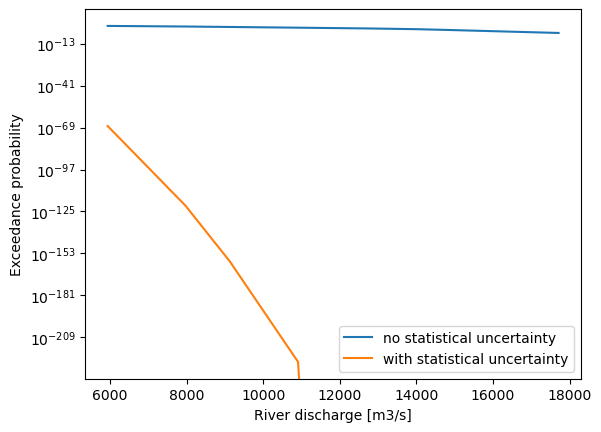

In [8]:
project.settings.reliability_method = "form"
Pf_with_stat_uncer = []

for w in Q_Pf["Q"]:

    project.variables["w"].mean = w
    project.run()
    beta = project.design_point.reliability_index 
    Pf_with_stat_uncer.append(StandardNormal.get_q_from_u(beta))

    print(beta)
    
plt.figure()
plt.semilogy(Q_Pf["Q"], Q_Pf["Pf"], label="no statistical uncertainty")
plt.semilogy(Q_Pf["Q"], Pf_with_stat_uncer, label="with statistical uncertainty")
plt.xlabel("River discharge [m3/s]")
plt.ylabel("Exceedance probability")
plt.legend()